In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import functools
import abc
import torch
import torch.nn as nn

from IPython.display import HTML
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import time

import hj_reachability as hj
from hj_reachability.finite_differences import upwind_first
jax.config.update('jax_platform_name', 'cpu')

In [2]:


dynamics = hj.systems.Air3d()
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(np.array([-6., -10., 0.]),
                                                                           np.array([20., 10., 2 * np.pi])),
                                                               (51, 40, 50),
                                                               periodic_dims=2)
values = jnp.linalg.norm(grid.states[..., :2], axis=-1) - 5

solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)

values.shape

E0805 19:29:06.528940  177180 cuda_dnn.cc:523] Loaded runtime CuDNN library: 9.5.1 but source was compiled with: 9.8.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0805 19:29:06.530681  177180 cuda_dnn.cc:523] Loaded runtime CuDNN library: 9.5.1 but source was compiled with: 9.8.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.


(51, 40, 50)

<Figure size 640x480 with 0 Axes>

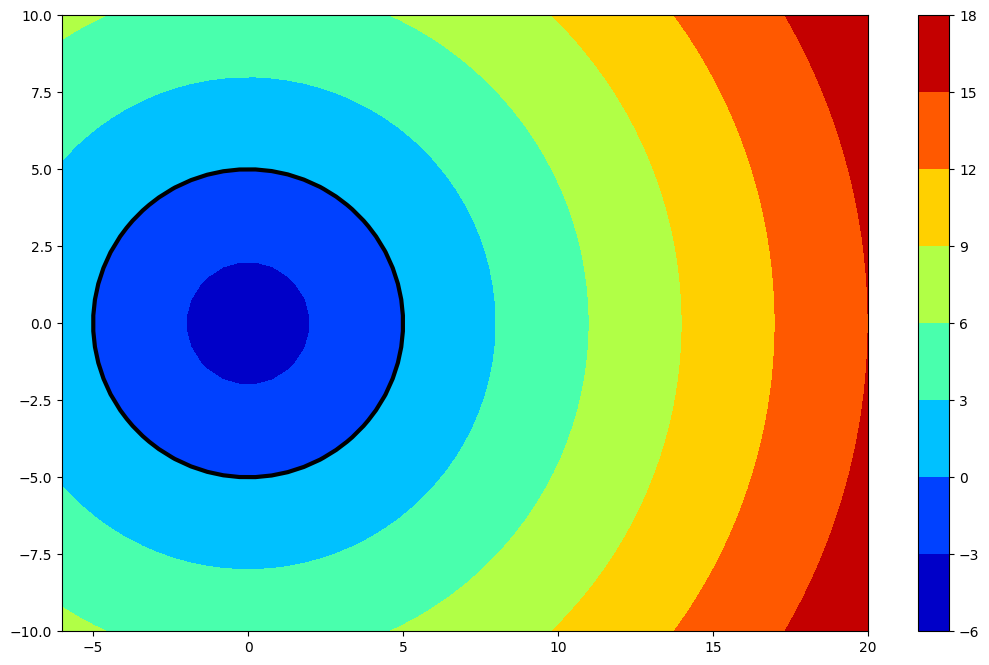

In [113]:
plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], values[:, :, 30].T)
plt.colorbar()
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            values[:, :, 30].T,
            levels=0,
            colors="black",
            linewidths=3)

In [114]:


time = 0.
target_time = -2.8
target_values = hj.step(solver_settings, dynamics, grid, time, values, target_time)



100%|##########|  2.8000/2.799999952316284 [00:03<00:00,  1.34s/sim_s]


In [120]:
values.shape, target_values.shape, grid.shape, grid.states.shape

((51, 40, 50), (51, 40, 50), (51, 40, 50), (51, 40, 50, 3))

<Figure size 640x480 with 0 Axes>

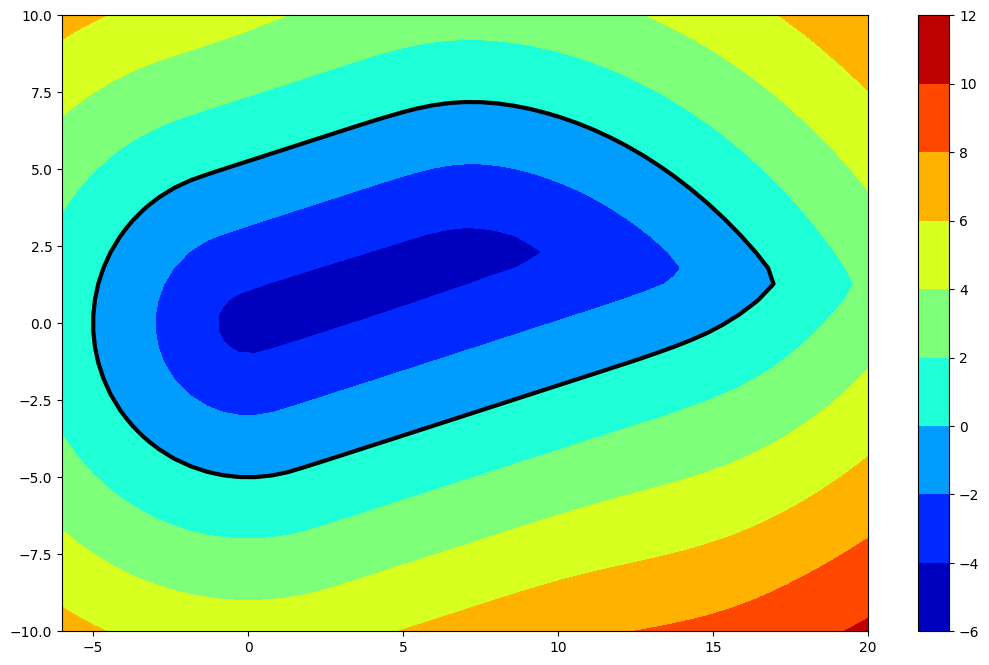

In [116]:
plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[:, :, 30].T)
plt.colorbar()
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            target_values[:, :, 30].T,
            levels=0,
            colors="black",
            linewidths=3)


In [117]:


go.Figure(data=go.Isosurface(x=grid.states[..., 0].ravel(),
                             y=grid.states[..., 1].ravel(),
                             z=grid.states[..., 2].ravel(),
                             value=target_values.ravel(),
                             colorscale="jet",
                             isomin=0,
                             surface_count=1,
                             isomax=0))



In [118]:


times = np.linspace(0, -2.8, 57)
initial_values = values
all_values = hj.solve(solver_settings, dynamics, grid, times, initial_values)




100%|##########|  2.8000/2.799999952316284 [00:03<00:00,  1.43s/sim_s]


In [119]:


vmin, vmax = all_values.min(), all_values.max()
levels = np.linspace(round(vmin), round(vmax), round(vmax) - round(vmin) + 1)
fig = plt.figure(figsize=(13, 8))


def render_frame(i, colorbar=False):
    plt.contourf(grid.coordinate_vectors[0],
                 grid.coordinate_vectors[1],
                 all_values[i, :, :, 30].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    if colorbar:
        plt.colorbar()
    plt.contour(grid.coordinate_vectors[0],
                grid.coordinate_vectors[1],
                target_values[:, :, 30].T,
                levels=0,
                colors="black",
                linewidths=3)


render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, all_values.shape[0], interval=50).to_html5_video())
plt.close(); animation



In [109]:
class AccelerationCurvatureCar(hj.ControlAndDisturbanceAffineDynamics):

    def __init__(self,
                 max_acceleration=1.,
                 max_curvature=1.,
                 max_position_disturbance=0.25,
                 control_mode="min",
                 disturbance_mode="max",
                 control_space=None,
                 disturbance_space=None):
        if control_space is None:
            control_space = hj.sets.Box(jnp.array([-max_acceleration, -max_curvature]),
                                        jnp.array([max_acceleration, max_curvature]))
        if disturbance_space is None:
            disturbance_space = hj.sets.Ball(jnp.zeros(2), max_position_disturbance)
        super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)

    def open_loop_dynamics(self, state, time):
        _, _, v, q = state
        return jnp.array([v * jnp.cos(q), v * jnp.sin(q), 0., 0.])

    def control_jacobian(self, state, time):
        v = state[2]
        return jnp.array([
            [0., 0.],
            [0., 0.],
            [1., 0.],
            [0., v],
        ])

    def disturbance_jacobian(self, state, time):
        return jnp.array([
            [1., 0.],
            [0., 1.],
            [0., 0.],
            [0., 0.],
        ])

In [110]:


dynamics = AccelerationCurvatureCar()
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(lo=np.array([-5., -5., -1., -np.pi]),
                                                                           hi=np.array([5., 5., 1., np.pi])),
                                                               (40, 40, 50, 50),
                                                               periodic_dims=3)
values = jnp.linalg.norm(grid.states[..., :2], axis=-1) - 1

solver_settings = hj.SolverSettings.with_accuracy("low")

grid.states[..., :2].shape



(40, 40, 50, 50, 2)

In [240]:


final_time = 0.
target_time = -2.0
target_values = hj.step(solver_settings, dynamics, grid, final_time, values, target_time)



100%|##########|  2.0000/2.0 [00:00<00:00, 16.60sim_s/s]


In [ ]:


go.Figure(data=go.Isosurface(x=grid.states[:, :, -1, :, 0].ravel(),
                             y=grid.states[:, :, -1, :, 1].ravel(),
                             z=grid.states[:, :, -1, :, 3].ravel(),
                             value=target_values[:, :, -1, :].ravel(),
                             colorscale='jet',
                             isomin=0,
                             surface_count=1,
                             isomax=0))



In [ ]:
class TaxiNetDynamics(hj.ControlAndDisturbanceAffineDynamics):

    def __init__(self,
                 dt=0.1,
                 velocity=5.,
                 L=5.,
                 max_rudder=jnp.tan(jnp.deg2rad(7.)),
                 max_position_disturbance=0.05,
                 max_yaw_disturbance=0.01,
                 control_mode="max",
                 disturbance_mode="min",
                 control_space=None,
                 disturbance_space=None):
        self.V = velocity
        self.L = L
        self.dt = dt

        if control_space is None:
            control_space = hj.sets.Box(jnp.array([-max_rudder]),
                                        jnp.array([max_rudder]))
        if disturbance_space is None:
            disturbance_space = hj.sets.Box(jnp.array([-max_position_disturbance, -max_yaw_disturbance]),
                                            jnp.array([max_position_disturbance, max_yaw_disturbance]))
        
        super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)

    def open_loop_dynamics(self, state, time):
        _, theta  = state
        return jnp.array([self.V * jnp.sin(theta), 0])

    def control_jacobian(self, state, time):
        return jnp.array([
            [0.],
            [self.V/self.L],
        ])

    def disturbance_jacobian(self, state, time):
        return jnp.array([
            [1., 0.],
            [0., 1.]
        ])

    def step(self, state, control, disturbance, time=0.):
        dxdt = self(state, control, disturbance, time)
        next_state = state + dxdt * self.dt
        return next_state

In [36]:
dynamics = TaxiNetDynamics(dt=0.1, max_rudder=jnp.tan(jnp.deg2rad(12.)))
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(np.array([-18., -np.pi/3]),
                                                                           np.array([18., np.pi/3])),
                                                               (100, 100),
                                                               )
values = -jnp.abs(grid.states[..., 0]) + 10

solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)


In [25]:
from matplotlib import colors as mcolors
import pypalettes
import matplotlib as mpl

rgb_colors = np.array(pypalettes.load_cmap("Alexandrite").rgb)/255.0
black = list(rgb_colors[0])
pink = list(rgb_colors[1])
dark_teal = list(rgb_colors[2])
light_teal = list(rgb_colors[3])
purple = list(rgb_colors[4])
orange = list(rgb_colors[5])
light_purple = list(rgb_colors[6])
teal = list(rgb_colors[7])
dark_orange = [255/255.0, 103/255.0, 0/255.0]

# Create a list of colors for the colormap
# This list will define the interpolation points
colors = [black, purple, dark_orange]

# Create the LinearSegmentedColormap
# The colormap will smoothly transition between the defined colors
custom_cmap = mcolors.LinearSegmentedColormap.from_list("purple2orange", colors)
cmap = custom_cmap
# mpl.colormaps.register(custom_cmap)

<Figure size 640x480 with 0 Axes>

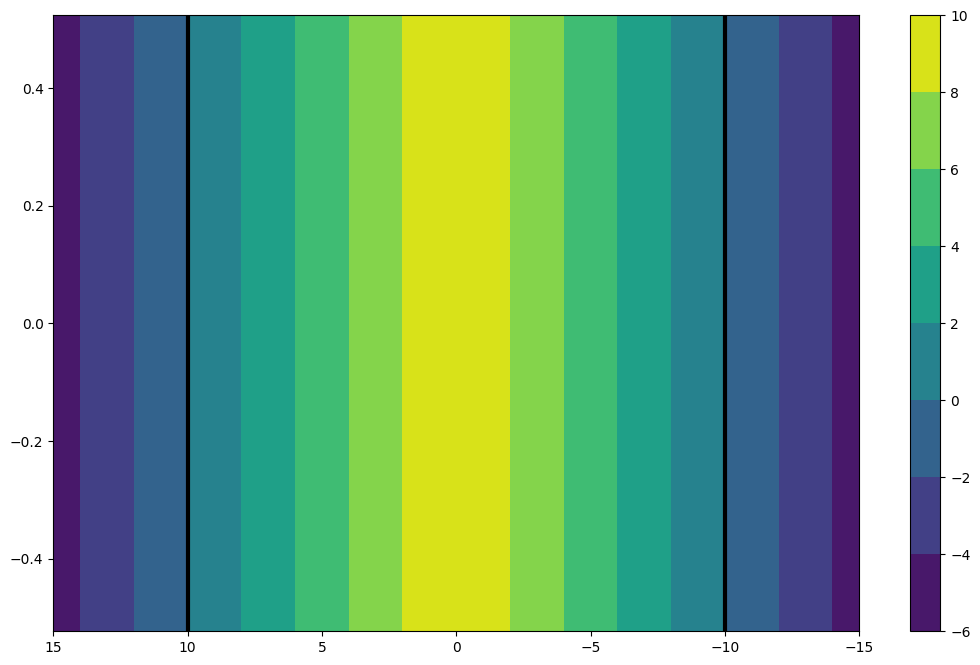

In [39]:
plt.set_cmap(cmap)
plt.figure(figsize=(13, 8))
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], values[:, :].T)
plt.colorbar()
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            values[:, :].T,
            levels=0,
            colors="black",
            linewidths=3)
plt.gca().invert_xaxis()

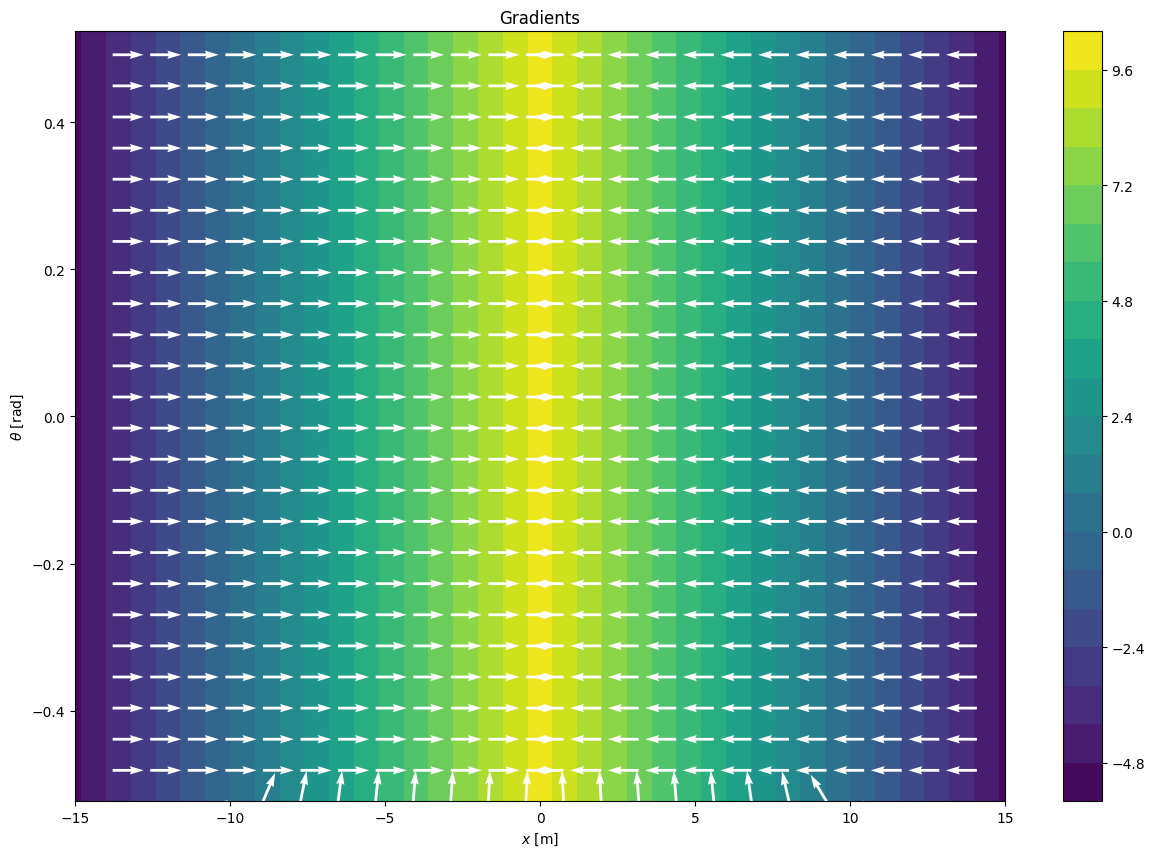

In [5]:
Gx = -jnp.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

Gy = -jnp.array([[-1, -2, -1],
                [0, 0, 0],
                [1, 2, 1]])

from jax.scipy.signal import convolve2d

# Assuming 'image' is your input JAX array representing the image
grad_x = convolve2d(values, Gx, mode='same')
grad_y = convolve2d(values, Gy, mode='same')

edge_direction = jnp.arctan2(grad_y, grad_x)
edge_magnitude = jnp.sqrt(grad_x**2 + grad_y**2)

grad_x_norm = grad_x / (edge_magnitude + 1e-8)
grad_y_norm = grad_y / (edge_magnitude + 1e-8)

plt.figure(figsize=(15, 10))
contour = plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], values[:, :].T, levels=20, cmap=cmap)
plt.colorbar(contour)
plt.title("Gradients")
plt.xlabel(r"$x$ [m]")
plt.ylabel(r"$\theta$ [rad]")

# Visualize only every 9th vector to show a 10x10 grid
step = 4
plt.quiver(
    grid.coordinate_vectors[0][::step],
    grid.coordinate_vectors[1][::step],
    grad_y_norm.T[::step, ::step],
    grad_x_norm.T[::step, ::step],
    color='white',
    scale=30,
    width=0.003
)
plt.show()

In [37]:
final_time = 0.
target_time = -10.0
target_values = hj.step(solver_settings, dynamics, grid, final_time, values, target_time)

 28%|##7       |  2.7586/10.0 [00:00<00:00, 27.42sim_s/s]/home/nick/.pyenv/versions/3.10.3/envs/hjnnv/lib/python3.10/site-packages/ipykernel/iostream.py:154: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7a15bcc89b60>
  self._event_pipes[threading.current_thread()] = event_pipe
 83%|########2 |  8.2760/10.0 [00:00<00:00, 25.64sim_s/s]/home/nick/.pyenv/versions/3.10.3/envs/hjnnv/lib/python3.10/site-packages/ipykernel/iostream.py:154: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7a151c72b610>
  self._event_pipes[threading.current_thread()] = event_pipe
/home/nick/.pyenv/versions/3.10.3/envs/hjnnv/lib/python3.10/site-packages/ipykernel/iostream.py:154: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7a151c72b680>
  self._event_pipes[threading.current_thread()] = event_pipe
100%|##########| 10.0000/10.0 [00:00<00:00, 26.16sim_s/s]


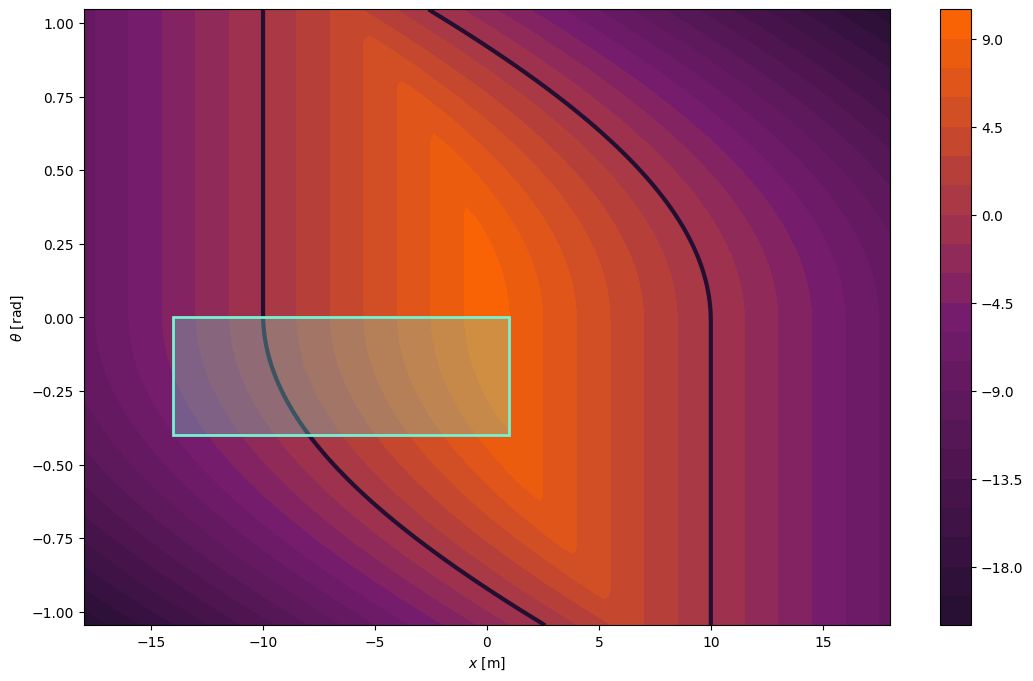

In [ ]:
plt.figure(figsize=(13, 8))
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[:, :].T, levels=20, cmap=cmap)
plt.colorbar()
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            target_values[:, :].T,
            levels=0,
            colors=black,
            linewidths=3)
plt.xlabel(r"$x$ [m]")
plt.ylabel(r"$\theta$ [rad]")

CTE_min, CTE_max = -2.95, 8.57
HE_min, HE_max = -32.6, 22.3
width = CTE_max - CTE_min
height = np.deg2rad(HE_max - HE_min)

rect = plt.Rectangle(
    (-2.95, ),
    ,
    8.57+2.95,
    linewidth=2,
    edgecolor=light_teal,
    facecolor=light_teal + [0.3],
    linestyle='-',
    label='state_bounds',
    zorder=5
)
plt.gca().add_patch(rect)

plt.show()

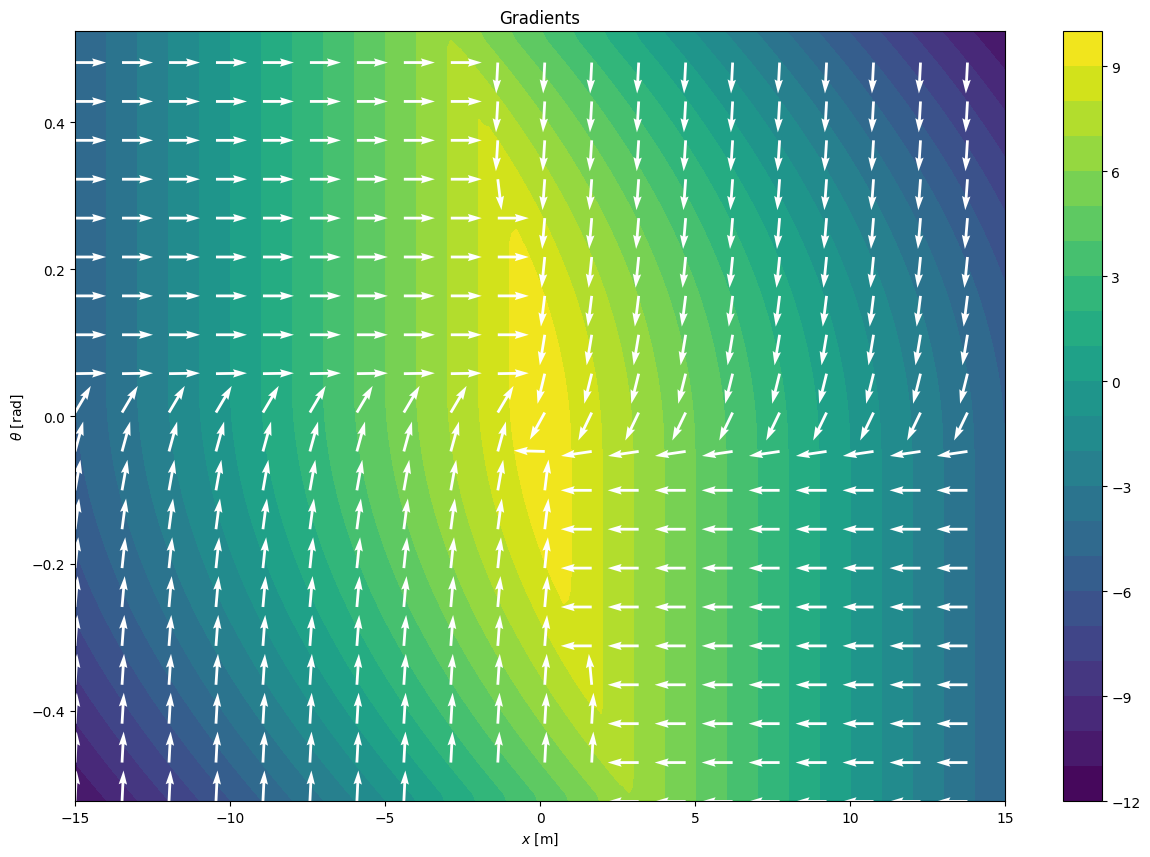

In [8]:
grads = grid.grad_values(target_values, upwind_scheme=upwind_first.WENO3)

plt.figure(figsize=(15, 10))
contour = plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[:, :].T, levels=20, cmap=cmap)
plt.colorbar(contour)
plt.title("Gradients")
plt.xlabel(r"$x$ [m]")
plt.ylabel(r"$\theta$ [rad]")
# plt.show()

# Normalize the gradient for direction only
U = grads[..., 0]
V = grads[..., 1]
magnitude = np.sqrt(U**2 + V**2)
U_norm = U / (magnitude + 1e-8)
V_norm = V / (magnitude + 1e-8)

# Visualize only every 9th vector to show a 10x10 grid
step = 5
plt.quiver(
    grid.coordinate_vectors[0][::step],
    grid.coordinate_vectors[1][::step],
    U_norm.T[::step, ::step],
    V_norm.T[::step, ::step],
    color='white',
    scale=30,
    width=0.003
)
plt.show()

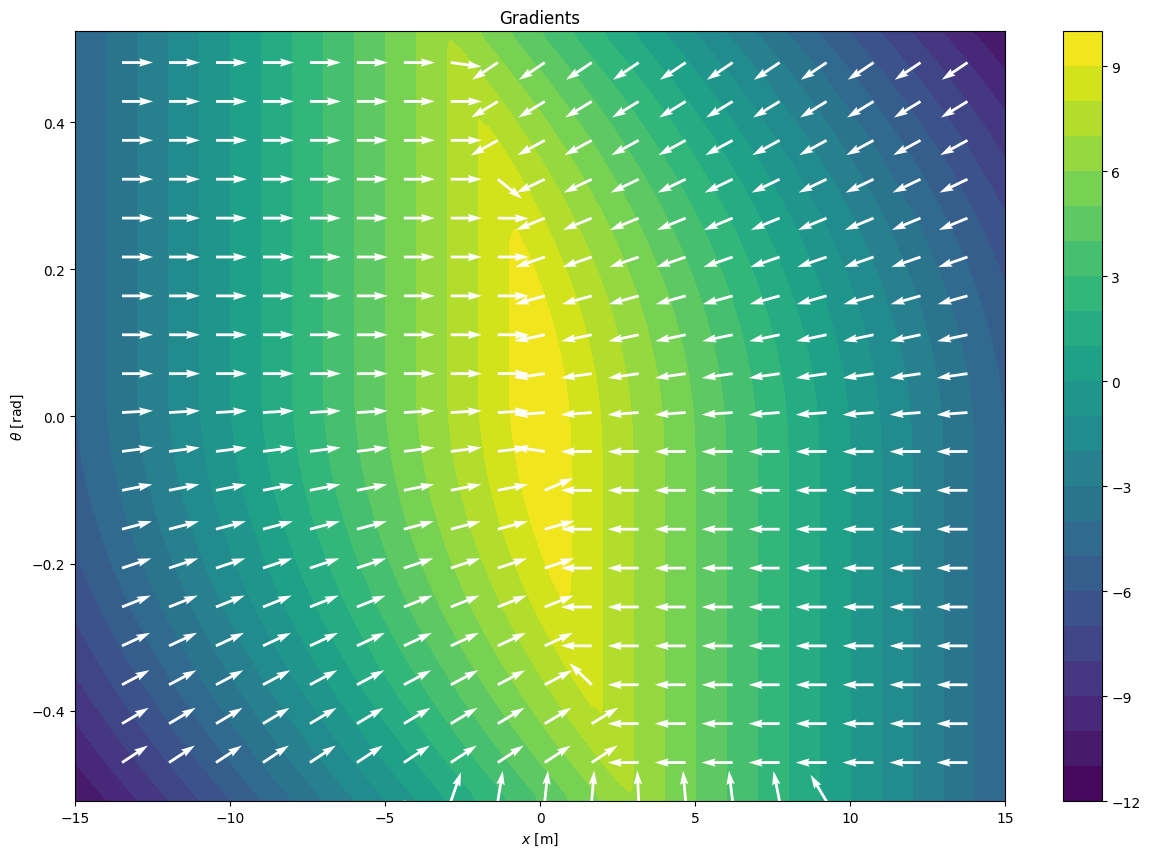

In [9]:
Gx = -jnp.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

Gy = -jnp.array([[-1, -2, -1],
                [0, 0, 0],
                [1, 2, 1]])

from jax.scipy.signal import convolve2d

# Assuming 'image' is your input JAX array representing the image
grad_x = convolve2d(target_values, Gx, mode='same')
grad_y = convolve2d(target_values, Gy, mode='same')

edge_direction = jnp.arctan2(grad_y, grad_x)
edge_magnitude = jnp.sqrt(grad_x**2 + grad_y**2)

grad_x_norm = grad_x / (edge_magnitude + 1e-8)
grad_y_norm = grad_y / (edge_magnitude + 1e-8)

plt.figure(figsize=(15, 10))
contour = plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[:, :].T, levels=20, cmap=cmap)
plt.colorbar(contour)
plt.title("Gradients")
plt.xlabel(r"$x$ [m]")
plt.ylabel(r"$\theta$ [rad]")

# Visualize only every 9th vector to show a 10x10 grid
step = 5
plt.quiver(
    grid.coordinate_vectors[0][::step],
    grid.coordinate_vectors[1][::step],
    grad_y_norm.T[::step, ::step],
    grad_x_norm.T[::step, ::step],
    color='white',
    scale=30,
    width=0.003
)
plt.show()



Loop execution time: 0.213 seconds


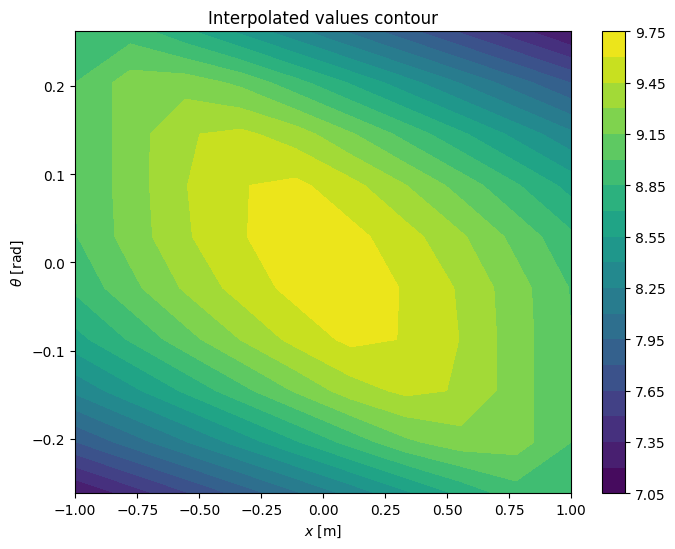

In [10]:
xbounds = 1
ybounds = np.pi/12

num_points = 10
x = np.linspace(-xbounds, xbounds, num_points)
y = np.linspace(-ybounds, ybounds, num_points)
X, Y = np.meshgrid(x, y)
points = np.stack([X.ravel(), Y.ravel()], axis=-1)
Z = np.zeros((num_points, num_points)).flatten()
start = time.time()
for i in range(points.shape[0]):
    Z[i] = grid.interpolate(target_values, points[i])
print(f"Loop execution time: {time.time() - start:.3f} seconds")

Z = Z.reshape(X.shape)

plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z, levels=20, cmap=cmap)
plt.colorbar(contour)
plt.title("Interpolated values contour")
plt.xlabel(r"$x$ [m]")
plt.ylabel(r"$\theta$ [rad]")
plt.show()

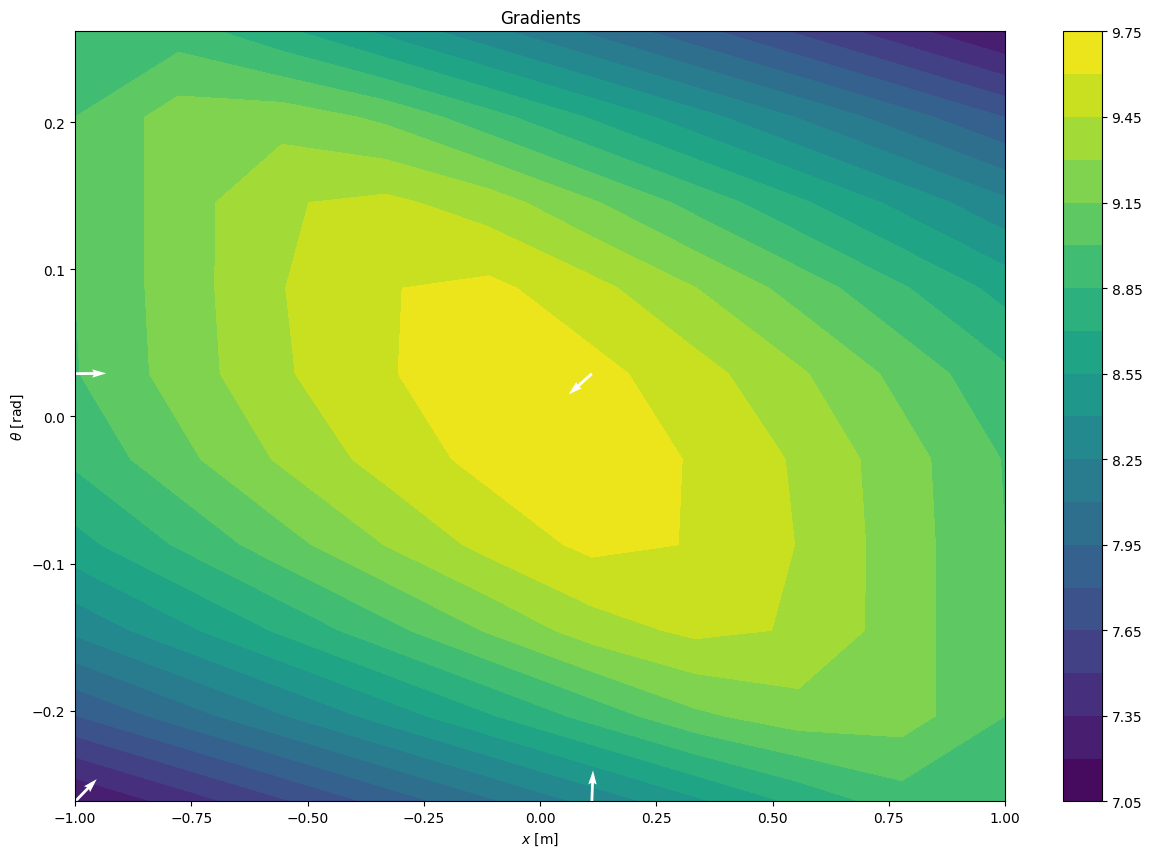

In [11]:
# Assuming 'image' is your input JAX array representing the image
grad_x = convolve2d(Z, Gx, mode='same')
grad_y = convolve2d(Z, Gy, mode='same')

edge_magnitude = jnp.sqrt(grad_x**2 + grad_y**2)

grad_x_norm = grad_x / (edge_magnitude + 1e-8)
grad_y_norm = grad_y / (edge_magnitude + 1e-8)

plt.figure(figsize=(15, 10))
contour = plt.contourf(X, Y, Z, levels=20, cmap=cmap)
plt.colorbar(contour)
plt.title("Gradients")
plt.xlabel(r"$x$ [m]")
plt.ylabel(r"$\theta$ [rad]")

# Visualize only every nth vector to show a reduced grid
step = 5
plt.quiver(
    X[::step, ::step],
    Y[::step, ::step],
    grad_x_norm[::step, ::step],
    grad_y_norm[::step, ::step],
    color='white',
    scale=30,
    width=0.003
)
plt.show()

In [12]:
18.8/(100*100)
X[0][0], grid.coordinate_vectors[1].shape

(np.float64(-1.0), (100,))

In [13]:
grad_values = grid.grad_values(target_values)

In [14]:
# @functools.partial(jax.jit, static_argnames=("num_controls", "num_disturbances", "num_states"))
def filter_state_bounds1(state_bounds, num_controls=10, num_disturbances=5, num_states=5):

    states = jnp.stack(jnp.meshgrid(jnp.linspace(state_bounds.lo[0], state_bounds.hi[0], num_states),
                                jnp.linspace(state_bounds.lo[1], state_bounds.hi[1], num_states)), axis=-1).reshape(-1, 2)
    controls = jnp.linspace(dynamics.control_space.lo[0], dynamics.control_space.hi[0], num_controls)
    disturbances = jnp.stack(jnp.meshgrid(jnp.linspace(dynamics.disturbance_space.lo[0], dynamics.disturbance_space.hi[0], num_disturbances),
                                jnp.linspace(dynamics.disturbance_space.lo[1], dynamics.disturbance_space.hi[1], num_disturbances)), axis=-1).reshape(-1, 2)

    # max_val = -jnp.inf
    
    def evaluate_u(u):
        def body(state):
            def inner(d):
                next_state = dynamics(state, jnp.array([u]), d, 0.)
                return grid.interpolate(target_values, next_state)
            values = jax.vmap(inner)(disturbances)
            return jnp.min(values)
        
        min_vals = jax.vmap(body)(states)
        min_val = jnp.min(min_vals)
        return min_val
    # def evaluate_u(u):
    #     min_val = jnp.inf
    #     for j in range(num_disturbances):
    #             for k in range(len(states)):
    #                 next_state = dynamics(states[k], jnp.array([u]), disturbances[j], 0.)
    #                 next_val = grid.interpolate(target_values, next_state)
    #                 if next_val < min_val:
    #                     min_val = next_val
    #                     min_state = states[k]
    #                     min_disturbance = disturbances[j]
    #     return min_val, min_state, min_disturbance

    # values = jnp.ones((num_controls))
    # for i, u in enumerate(controls):
    #     values = values.at[i].set(evaluate_u(u)[0])
    #     print(evaluate_u(u)[0])
    values = jax.vmap(evaluate_u)(controls)
    optimal_control = controls[jnp.argmax(values)]
    v_star = jnp.max(values)

    return v_star, optimal_control




In [15]:
# @functools.partial(jax.jit, static_argnames=("num_controls", "num_disturbances", "num_states"))
def filter_state_bounds2(state_bounds, num_controls=10, num_disturbances=5, num_states=5):

    states = jnp.stack(jnp.meshgrid(jnp.linspace(state_bounds.lo[0], state_bounds.hi[0], num_states),
                                jnp.linspace(state_bounds.lo[1], state_bounds.hi[1], num_states)), axis=-1).reshape(-1, 2)
    controls = jnp.linspace(dynamics.control_space.lo[0], dynamics.control_space.hi[0], num_controls)
    disturbances = jnp.stack(jnp.meshgrid(jnp.linspace(dynamics.disturbance_space.lo[0], dynamics.disturbance_space.hi[0], num_disturbances),
                                jnp.linspace(dynamics.disturbance_space.lo[1], dynamics.disturbance_space.hi[1], num_disturbances)), axis=-1).reshape(-1, 2)

    def evaluate_u(u):
        min_val = jnp.inf
        for j in range(len(disturbances)):
                for k in range(len(states)):
                    next_state = dynamics(states[k], jnp.array([u]), disturbances[j], 0.)
                    next_val = grid.interpolate(target_values, next_state)
                    if next_val < min_val:
                        min_val = next_val
                        min_state = states[k]
                        min_disturbance = disturbances[j]
        return min_val, min_state, min_disturbance

    values = jnp.ones((num_controls))
    for i, u in enumerate(controls):
        values = values.at[i].set(evaluate_u(u)[0])
    optimal_control = controls[jnp.argmax(values)]
    v_star = jnp.max(values)

    return v_star, optimal_control


In [6]:
@functools.partial(jax.jit, static_argnames=("num_controls", "num_disturbances", "num_states"))
def uncertainty_aware_filter(u_control, state_bounds, num_controls=10, num_disturbances=5, num_states=5):
    # Construct grids
    x1 = jnp.linspace(state_bounds.lo[0], state_bounds.hi[0], num_states)
    x2 = jnp.linspace(state_bounds.lo[1], state_bounds.hi[1], num_states)
    states = jnp.stack(jnp.meshgrid(x1, x2, indexing="ij"), axis=-1).reshape(-1, 2)

    u_vals = jnp.linspace(dynamics.control_space.lo[0], dynamics.control_space.hi[0], num_controls)

    d1 = jnp.linspace(dynamics.disturbance_space.lo[0], dynamics.disturbance_space.hi[0], num_disturbances)
    d2 = jnp.linspace(dynamics.disturbance_space.lo[1], dynamics.disturbance_space.hi[1], num_disturbances)
    disturbances = jnp.stack(jnp.meshgrid(d1, d2, indexing="ij"), axis=-1).reshape(-1, 2)

    # Total combinations
    num_d = disturbances.shape[0]

    def evaluate_u(u):
        # Compute f(x, u, d) for all x and d
        def eval_x_d(x):
            def eval_d(d):
                next_state = dynamics.step(x, jnp.array([u]), d, 0.)
                # next_state = x + dxdt * dynamics.dt
                val = grid.interpolate(target_values, next_state)
                return val
            return jax.vmap(eval_d)(disturbances)

        vals = jax.vmap(eval_x_d)(states)  # shape (num_x, num_d)
        vals = vals.reshape(-1)
        min_idx = jnp.argmin(vals)
        min_val = vals[min_idx]

        # Recover the x and d that caused this minimum
        min_x_idx = min_idx // num_d
        min_d_idx = min_idx % num_d
        return min_val, states[min_x_idx], disturbances[min_d_idx]

    # Check nominal u value from controller
    val_filter, _, _ = evaluate_u(u_control)

    

    # Vectorize over all controls
    min_vals, min_states, min_disturbances = jax.vmap(evaluate_u)(u_vals)
    best_u_idx = jnp.argmax(min_vals)
    worst_val = jnp.min(min_vals)
    best_val = min_vals[best_u_idx]
    best_u = u_vals[best_u_idx]

    return best_val, best_u, worst_val, val_filter

In [7]:
xbounds = 0.1
ybounds = 0.1
state_bounds = hj.sets.Box(
    np.array([-9.5, -0.01]),
    np.array([9.5, 0.03])
)
# state_bounds = hj.sets.Box(
#     np.array([1.7302322, -7.1525574e-07]),
#     np.array([5.998444, 3.836559])
# )

num_states = 10
num_controls = 20
num_disturbances = 10

In [9]:
# time_start = time.time()
# v, u_star = filter_state_bounds2(state_bounds, num_controls=num_controls, num_disturbances=num_disturbances, num_states=num_states)
# print(f"Execution time with for loops: {time.time() - time_start:.3f} seconds")

# print(f"Optimal value: {v}, Optimal control: {u_star}")

# print("--------------------------------------------------")

# time_start = time.time()
# v, u_star = filter_state_bounds1(state_bounds, num_controls=num_controls, num_disturbances=num_disturbances, num_states=num_states)
# print(f"My modified: {time.time() - time_start:.3f} seconds")

# print(f"Optimal value: {v}, Optimal control: {u_star}")

# print("--------------------------------------------------")

time_start = time.time()
v, u_star, min_v, v_filter = uncertainty_aware_filter(
    dynamics.control_space.hi[0]/2,
    state_bounds,
    num_controls=num_controls,
    num_disturbances=num_disturbances,
    num_states=num_states
)
time_finish_1 = time.time()
v_f_float = float(v_filter)
u_star_float = float(u_star)
time_finish_2 = time.time()

print(f"Execution time 1: {time_finish_1 - time_start:.5f} seconds")
print(f"Execution time 2: {time_finish_2 - time_finish_1:.5f} seconds")

print(f"Optimal value: {v}, Optimal control: {u_star}, Worst value: {min_v}, Nominal Control Value: {v_filter}")

Execution time 1: 0.00160 seconds
Execution time 2: 0.00540 seconds
Optimal value: 0.4600267708301544, Optimal control: -0.1227845698595047, Worst value: 0.414930522441864, Nominal Control Value: 0.42924952507019043


In [14]:
dynamics.control_space.hi[0]/2

Array(0.06139228, dtype=float32)

In [10]:
def get_next_state_bounds(u, state_bounds):
    x1 = jnp.linspace(state_bounds.lo[0], state_bounds.hi[0], num_states)
    x2 = jnp.linspace(state_bounds.lo[1], state_bounds.hi[1], num_states)
    states = jnp.stack(jnp.meshgrid(x1, x2, indexing="ij"), axis=-1).reshape(-1, 2)

    d1 = jnp.linspace(dynamics.disturbance_space.lo[0], dynamics.disturbance_space.hi[0], num_disturbances)
    d2 = jnp.linspace(dynamics.disturbance_space.lo[1], dynamics.disturbance_space.hi[1], num_disturbances)
    disturbances = jnp.stack(jnp.meshgrid(d1, d2, indexing="ij"), axis=-1).reshape(-1, 2)

    def eval_next_state(x):
        def eval_d(d):
            dxdt = dynamics(x, jnp.array([u]), d, 0.)
            return x + dxdt * dynamics.dt
        return jax.vmap(eval_d)(disturbances)  # shape (num_d, state_dim)

    next_states = jax.vmap(eval_next_state)(states)  # shape (num_states, num_d, state_dim)
    next_states = next_states.reshape(-1, states.shape[1])  # flatten to (num_states*num_d, state_dim)

    min_next = jnp.min(next_states, axis=0)  # shape (state_dim,)
    max_next = jnp.max(next_states, axis=0)

    return min_next, max_next

In [11]:
state_bounds = hj.sets.Box(
    np.array([-9.5, -0.1]),
    np.array([9.5, 0.1])
)
u_applied = dynamics.control_space.hi[0] / 2

Execution time: 0.00139 seconds
Optimal value: 0.16652511060237885, Optimal control: 0.006462350487709045, Worst value: 0.10578736662864685, Nominal Control Value: 0.13833048939704895


<Figure size 640x480 with 0 Axes>

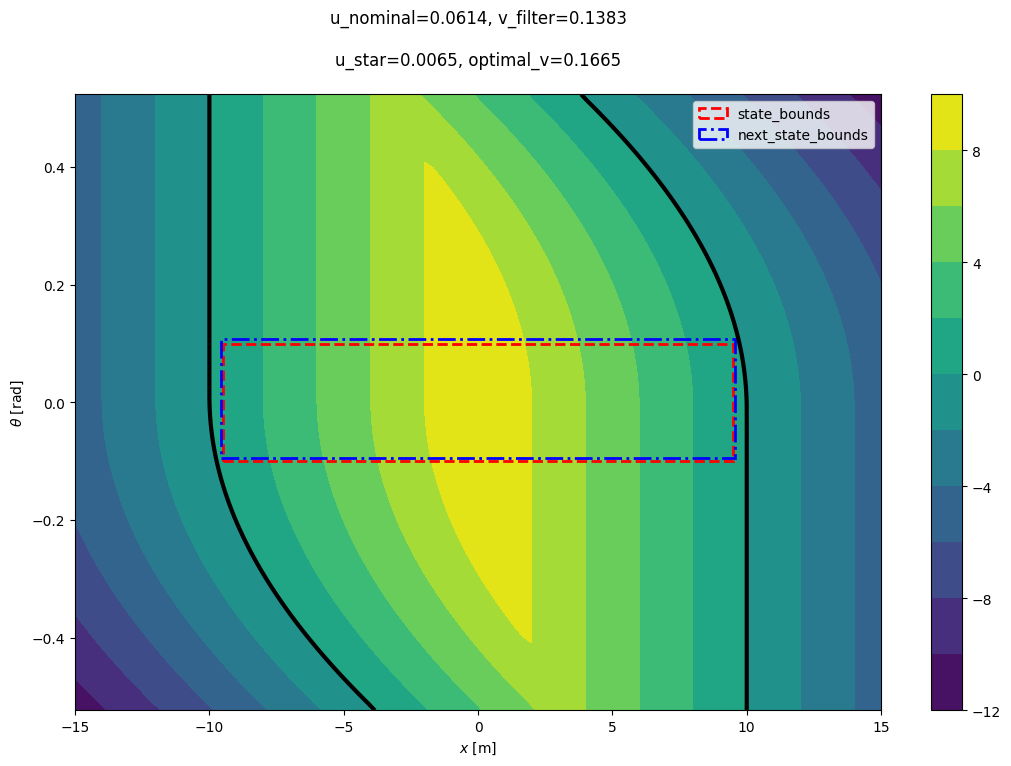

In [12]:
time_start = time.time()
v, u_star, min_v, v_filter = uncertainty_aware_filter(
    u_applied,
    state_bounds,
    num_controls=num_controls,
    num_disturbances=num_disturbances,
    num_states=num_states
)
time_finish = time.time()
print(f"Execution time: {time_finish - time_start:.5f} seconds")

print(f"Optimal value: {v}, Optimal control: {u_star}, Worst value: {min_v}, Nominal Control Value: {v_filter}")

min_next_state, max_next_state = get_next_state_bounds(u_applied, state_bounds)

plt.set_cmap(cmap)
plt.figure(figsize=(13, 8))
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[:, :].T, levels=10)
plt.colorbar()
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            target_values[:, :].T,
            levels=0,
            colors="black",
            linewidths=3)
plt.xlabel(r"$x$ [m]")
plt.ylabel(r"$\theta$ [rad]")

# Plot rectangle for state_bounds
rect = plt.Rectangle(
    (state_bounds.lo[0], state_bounds.lo[1]),
    state_bounds.hi[0] - state_bounds.lo[0],
    state_bounds.hi[1] - state_bounds.lo[1],
    linewidth=2,
    edgecolor='red',
    facecolor='none',
    linestyle='--',
    label='state_bounds'
)
plt.gca().add_patch(rect)

# Plot rectangle for next_state bounds
rect_next = plt.Rectangle(
    (min_next_state[0], min_next_state[1]),
    max_next_state[0] - min_next_state[0],
    max_next_state[1] - min_next_state[1],
    linewidth=2,
    edgecolor='blue',
    facecolor='none',
    linestyle='-.',
    label='next_state_bounds'
)
plt.gca().add_patch(rect_next)
plt.legend()

plt.title(
    f"u_nominal={u_applied:.4f}, v_filter={v_filter:.4f}\n\n"
    f"u_star={u_star:.4f}, optimal_v={v:.4f}\n"
)
plt.show()

In [19]:
# jax.devices("gpu")[0]
import jax
jax.devices()
import jax_verify

# bounds = jax_verify.backward_crown_bound_propagation(fun_to_prop, inp_bound)


# Beacon Example

In [2]:
class MLP(nn.Module):
    def __init__(self, in_dim=6, out_dim=4, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, out_dim),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# class HJNNVDynamics(hj.ControlAndDisturbanceAffineDynamics):
#     def __init__(self,
#                  dt=0.1,
#                  control_mode="max",
#                  disturbance_mode="min",
#                  control_space=None,
#                  disturbance_space=None):
#         self.dt = dt
#         super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)

#     @abc.abstractmethod
#     def open_loop_dynamics(self, state, time):
#         """Implements the open loop dynamics `f(x, t)`."""

#     @abc.abstractmethod
#     def control_jacobian(self, state, time):
#         """Implements the control Jacobian `G_u(x, t)`."""

#     @abc.abstractmethod
#     def disturbance_jacobian(self, state, time):
#         """Implements the disturbance Jacobian `G_d(x, t)`."""

#     @abc.abstractmethod
#     def get_observation(self, state, time):
#         """Implements the observation function `h(x, t)`."""

#     def step(self, state, control, disturbance, time=0.):
#         dxdt = self(state, control, disturbance, time)
#         next_state = state + dxdt * self.dt
#         return next_state

#     def get_random_disturbance(self):
#         if isinstance(self.disturbance_space, hj.sets.Box):
#             lo = self.disturbance_space.lo
#             hi = self.disturbance_space.hi
#             return jax.random.uniform(jax.random.PRNGKey(0), shape=lo.shape, minval=lo, maxval=hi)
#         else:
#             raise NotImplementedError(
#                 "Only Box disturbance space is supported for random sampling."
#             )

#     def simulate_trajectory(self, initial_state, control_policy, num_steps, use_observations=False):
#         state = initial_state
#         trajectory = [(state, self.get_observation(state, time=0))]
#         for t in range(num_steps):
#             if use_observations:
#                 obs = self.get_observation(state, time=t)
#                 state_hat = self.get_state_estimate(obs)
#             else:
#                 state_hat = state
#             # import ipdb; ipdb.set_trace()
#             control = control_policy(state_hat)
#             disturbance = self.get_random_disturbance()
#             state = self.step(state, control, disturbance, time=t+1)
#             observation = self.get_observation(state, time=t+1)
#             trajectory.append((state, observation))
#         return trajectory


In [ ]:
# class BeaconDynamics(HJNNVDynamics):

#     def __init__(self,
#                  dt=0.1,
#                  max_input=1.0,
#                  max_position_disturbance=0.01,
#                  max_vel_disturbance=0.005,
#                  range_disturbance=0.02,
#                  control_mode="max",
#                  disturbance_mode="min",
#                  control_space=None,
#                  disturbance_space=None):

#         if control_space is None:
#             control_space = hj.sets.Box(jnp.array([-max_input, -max_input]),
#                                         jnp.array([max_input, max_input]))
#         if disturbance_space is None:
#             disturbance_space = hj.sets.Box(
#                 jnp.array([
#                     -max_position_disturbance,
#                     -max_position_disturbance,
#                     -max_vel_disturbance,
#                     -max_vel_disturbance
#                 ]),
#                 jnp.array([
#                     max_position_disturbance,
#                     max_position_disturbance,
#                     max_vel_disturbance,
#                     max_vel_disturbance
#                 ])
#             )

#         self.beacons = jnp.array([[0.0, 0.0], [8.0, 0.0], [0.0, 8.0], [4.0, 4.0]])
#         self.range_disturbance = range_disturbance
#         self.load_estimator()
#         self.previous_observations = jnp.array([0., 0.])


#         super().__init__(dt, control_mode, disturbance_mode, control_space, disturbance_space)

#     def open_loop_dynamics(self, state, time):
#         _, _, vx, vy = state
#         return jnp.array([vx, vy, 0., 0.])

#     def control_jacobian(self, state, time):
#         return jnp.array([
#             [0.5 * self.dt, 0.],
#             [0., 0.5 * self.dt],
#             [1., 0.],
#             [0., 1.]
#         ])

#     def disturbance_jacobian(self, state, time):
#         return jnp.eye(4)

#     def get_observation(self, state, time):
#         pos = jnp.array([state[0], state[1]])
#         d = jnp.linalg.norm(self.beacons - pos, axis=1)  # (3,)
#         d_noisy = d + jax.random.uniform(
#             jax.random.PRNGKey(0),
#             shape=d.shape,
#             minval=-self.range_disturbance,
#             maxval=self.range_disturbance
#         )
#         if time == 0:
#             self.previous_observations = jnp.concatenate([d_noisy, d_noisy], axis=0)
#             # import ipdb; ipdb.set_trace()
#             return jnp.concatenate([d_noisy, d_noisy, d_noisy], axis=0)
#         elif time == 1:
#             # import ipdb; ipdb.set_trace()
#             self.previous_observations = jnp.concatenate(
#                 [self.previous_observations[4:], d_noisy],
#                 axis=0
#             )
#             return jnp.concatenate([self.previous_observations, d_noisy], axis=0)
#         else:
#             d_noisy_seq = jnp.concatenate([self.previous_observations, d_noisy])
#             # import ipdb; ipdb.set_trace()
#             self.previous_observations = d_noisy_seq[4:]

#         return d_noisy_seq

#     def load_estimator(self):
#         checkpoint = torch.load(
#             "/home/nick/code/hjnnv/src/learned_models/beacon/estimators/simple_estimator_3t/best_model.pt",
#             map_location="cpu",
#         )

#         config = checkpoint.get("config_dict", None)
#         self.estimator = MLP(in_dim=12, out_dim=4, hidden=config["hidden"])

#         # load just the weights
#         self.estimator.load_state_dict(checkpoint["model_state_dict"])
#         self.estimator.eval()

#         # optional: keep normalization params if you need them later
#         self.in_mean = checkpoint.get("in_mean", None)
#         self.in_std = checkpoint.get("in_std", None)

#     def get_state_estimate(self, obs):
#         obs = torch.tensor(np.array(obs)).unsqueeze(0)
#         obs = (obs - self.in_mean) / self.in_std
#         with torch.no_grad():
#             state_hat = self.estimator(obs).detach().numpy()
#         return state_hat


In [2]:
from dynamic_models.beacon import BeaconDynamics


In [ ]:
dynamics = BeaconDynamics(
    max_position_disturbance=0.001,
    max_vel_disturbance=0.001,
    range_disturbance=0.1
)
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
            hj.sets.Box(
                np.array([-5., -5., -5., -5.]),
                np.array([15., 15., 5., 5.])),
            (30, 30, 20, 20),
        )
values_ = jnp.stack([jnp.abs(grid.states[..., 0] - 5.), jnp.abs(grid.states[..., 1] - 5.)], axis=-1)
values = -jnp.max(values_, axis=-1) + 5.

solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)
cmap = 'viridis'

In [7]:
final_time = 0.
target_time = -10.0
target_values = hj.step(solver_settings, dynamics, grid, final_time, values, target_time)

100%|##########| 10.0000/10.0 [00:22<00:00,  2.25s/sim_s]


<Figure size 640x480 with 0 Axes>

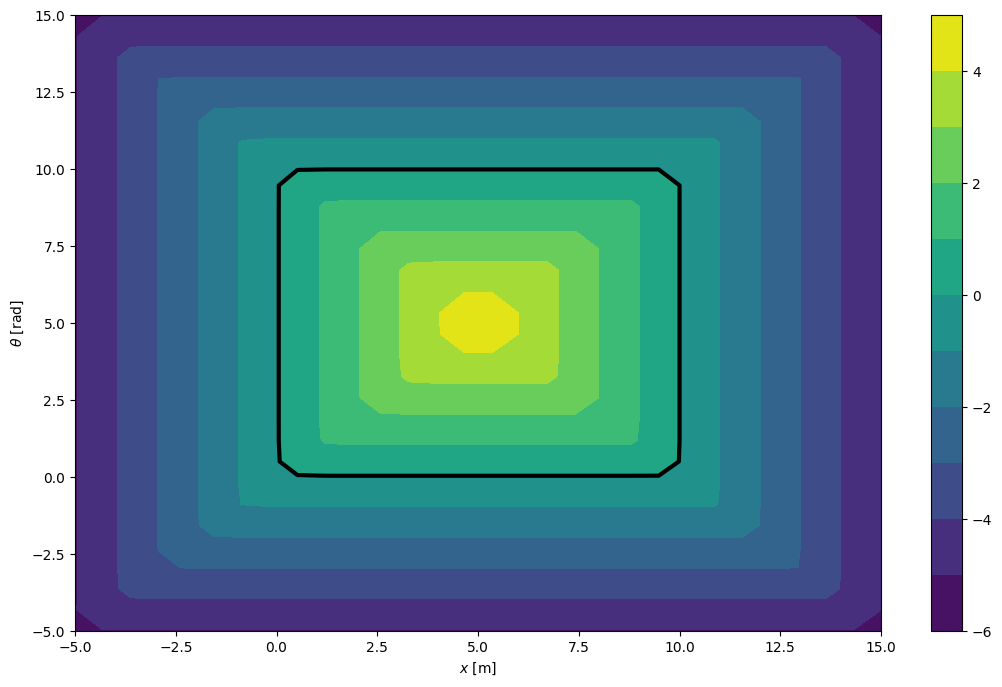

In [8]:
level_set = 9

plt.set_cmap(cmap)
plt.figure(figsize=(13, 8))
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[:, :, level_set, level_set].T, levels=10)
plt.colorbar()
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            target_values[:, :, level_set, level_set].T,
            levels=0,
            colors="black",
            linewidths=3)
plt.xlabel(r"$x$ [m]")
plt.ylabel(r"$\theta$ [rad]")
plt.show()

In [4]:
from hjnnv import hjnnvUncertaintyAwareFilter

In [20]:
hjnnv_filter = hjnnvUncertaintyAwareFilter(
    dynamics=dynamics,
    pred_model=dynamics.get_state_estimate,
    grid=grid,
    initial_values=values,
    num_controls=3,
    num_disturbances=3
)

100%|##########| 10.0000/10.0 [00:22<00:00,  2.26s/sim_s]


In [6]:
state = jnp.array([9.0, 5.5, 1.0, 0.5])
state_history = []
state_hat_history = []
num_steps = 500

for step in range(num_steps):
    # Simulate the system dynamics
    obs = dynamics.get_observation(state, time=step)
    state_hat = dynamics.get_state_estimate(obs)

    state_bounds = hjnnv_filter.state_bounds_from_gt(
        jnp.array(state_hat),
        state
    )

    time_start = time.time()
    v_star, u_star, worst_val, val_filter = hjnnv_filter.ua_filter(
        jnp.array([0., 0.]),
        state_bounds,
        num_states=2,
    )

    if val_filter < 0.0:
        u = u_star
    else:
        u = jnp.array([0., 0.])
    time_end = time.time()

    print(f"Step {step}: State: {state}")
    print(f"Step {step}: Estimated State: {state_hat}")

    print(f"Step {step}: u_star={u}, val_filter={val_filter}")
    print(f"Step {step}: Execution time: {time_end - time_start:.5f} seconds")

    # Store the state
    state_history.append(state)
    state_hat_history.append(state_hat)

    state = dynamics.step(state, u, dynamics.get_random_disturbance(), time=step)

ValueError: Arguments to jax.numpy.meshgrid must be 1D, got shapes [(2, 4)]

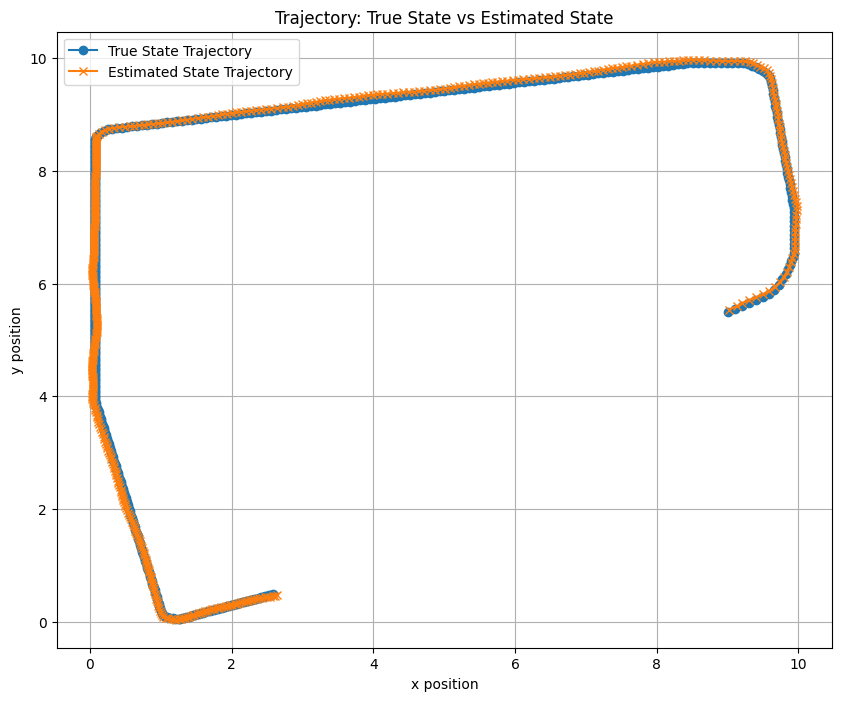

In [50]:
state_history = jnp.stack(state_history)
state_hat_history = jnp.stack(state_hat_history)

plt.figure(figsize=(10, 8))
plt.plot(state_history[:, 0], state_history[:, 1], label="True State Trajectory", marker='o')
plt.plot(state_hat_history[:, 0], state_hat_history[:, 1], label="Estimated State Trajectory", marker='x')
plt.xlabel("x position")
plt.ylabel("y position")
plt.title("Trajectory: True State vs Estimated State")
plt.legend()
plt.grid(True)
plt.show()

time_stamps: [  0.  15.  30.  45.  60.  75.  90. 105. 120. 135. 150. 165.]
diffs: [15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.]


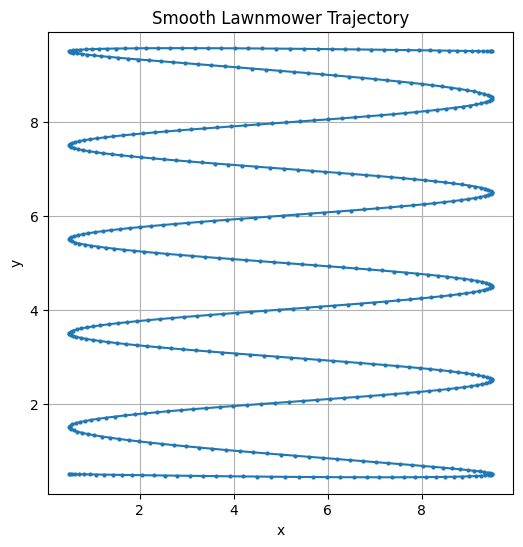

In [6]:
from scipy.interpolate import CubicSpline

# Parameters
square_size = 9
lane_width = 1.0
num_lanes = int(square_size / lane_width) + 1
points_per_lane = 50
T_lane = 15.0  # seconds per lane

waypoints_x = []
waypoints_y = []
time_stamps = []

t = 0.0
for i in range(num_lanes):
    y = i * lane_width
    if i % 2 == 0:
        x_start, x_end = 0, square_size
    else:
        x_start, x_end = square_size, 0
    
    # Only append the start of the lane if this is the first lane or first point
    if i == 0:
        waypoints_x.append(x_start)
        waypoints_y.append(y)
        time_stamps.append(t)
    
    # Append end of the lane
    t += T_lane
    waypoints_x.append(x_end)
    waypoints_y.append(y)
    time_stamps.append(t)

    if i == num_lanes - 1:
        waypoints_x.append(x_start)
        waypoints_y.append(y)
        time_stamps.append(t + T_lane)

waypoints_x = np.array(waypoints_x)
waypoints_y = np.array(waypoints_y)
time_stamps = np.array(time_stamps)

print("time_stamps:", time_stamps)
print("diffs:", np.diff(time_stamps))  # should all be > 0

# Cubic splines with zero velocities at start and end
spline_x = CubicSpline(time_stamps, waypoints_x + 0.5, bc_type=((1,0.0),(1,0.0)))
spline_y = CubicSpline(time_stamps, waypoints_y + 0.5, bc_type=((1,0.0),(1,0.0)))

t_samples = np.linspace(0, time_stamps[-1], num_lanes * points_per_lane)
x_traj = spline_x(t_samples)
y_traj = spline_y(t_samples)
vx_traj = spline_x(t_samples, 1)
vy_traj = spline_y(t_samples, 1)
ax_traj = spline_x(t_samples, 2)
ay_traj = spline_y(t_samples, 2)

# Plot trajectory
plt.figure(figsize=(6,6))
plt.plot(x_traj, y_traj, '-o', markersize=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Smooth Lawnmower Trajectory')
plt.axis('equal')
plt.grid(True)
plt.show()


In [7]:
def rov_controller(state, time):
    ax_des = spline_x(time, 2)
    ay_des = spline_y(time, 2)
    vx_des = spline_x(time, 1)
    vy_des = spline_y(time, 1)
    x_des = spline_x(time)
    y_des = spline_y(time)

    kp = 2.0  # Control gain
    kd = 2.0  # Derivative gain

    ux = ax_des + kp * (x_des - state[0]) + kd * (vx_des - state[2])
    uy = ay_des + kp * (y_des - state[1]) + kd * (vy_des - state[3])

    u = jnp.array([ux, uy])
    u_clipped = jnp.clip(u, -1.0, 1.0)
    return u_clipped

In [21]:
state = jnp.array([0.5, 0.5, 0.0, 0.0])
state_history = []
state_hat_history = []
num_steps = 1650

for step in range(num_steps):
    t = step * dynamics.dt
    # Simulate the system dynamics
    obs = dynamics.get_observation(state, time=step)
    state_hat = dynamics.get_state_estimate(obs).flatten()

    state_bounds = hjnnv_filter.state_bounds_from_gt(
        jnp.array(state_hat),
        state
    )

    u_nominal = rov_controller(state_hat, t)

    time_start = time.time()
    v_star, u_star, worst_val, val_filter = hjnnv_filter.ua_filter(
        u_nominal,
        state_bounds,
        num_states=2,
    )

    if val_filter < 0.0:
        u = u_star
    else:
        u = u_nominal
    time_end = time.time()

    # print(f"Step {step}: State: {state}")
    # print(f"Step {step}: Estimated State: {state_hat}")

    # print(f"Step {step}: u_star={u}, val_filter={val_filter}")
    # print(f"Step {step}: Execution time: {time_end - time_start:.5f} seconds")

    # Store the state
    state_history.append(state)
    state_hat_history.append(state_hat)

    state = dynamics.step(state, u, dynamics.get_random_disturbance(), time=step)

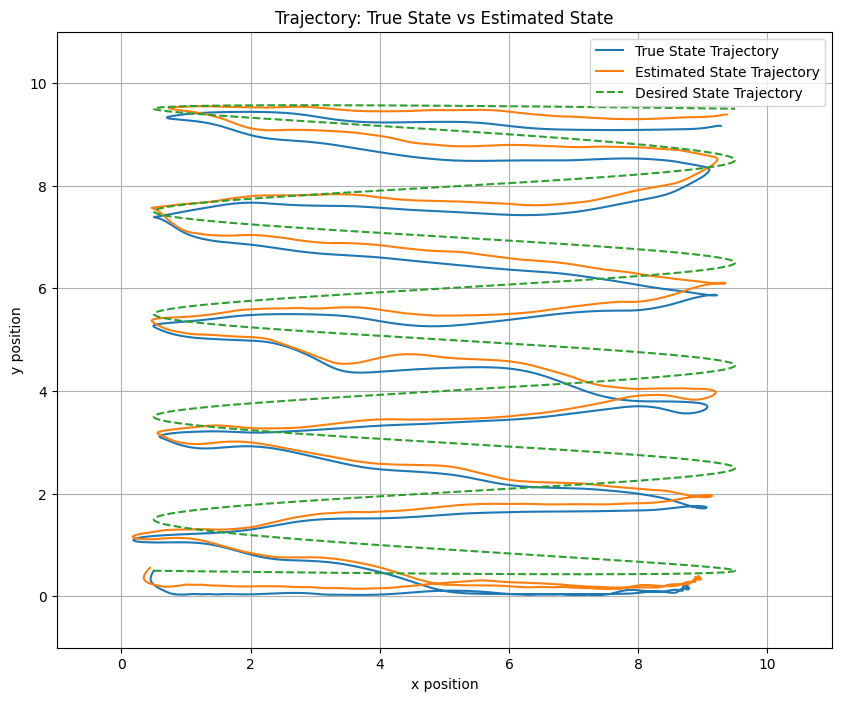

In [22]:
state_history = jnp.stack(state_history)
state_hat_history = jnp.stack(state_hat_history)

t_samples = np.linspace(0, num_steps * dynamics.dt, num_steps)
x_des_history = spline_x(t_samples, 0)
y_des_history = spline_y(t_samples, 0)

plt.figure(figsize=(10, 8))
plt.plot(state_history[:, 0], state_history[:, 1], label="True State Trajectory")
plt.plot(state_hat_history[:, 0], state_hat_history[:, 1], label="Estimated State Trajectory")
plt.plot(x_des_history, y_des_history, label="Desired State Trajectory", linestyle='--')
plt.xlabel("x position")
plt.ylabel("y position")
plt.title("Trajectory: True State vs Estimated State")
plt.legend(loc="upper right")
plt.xlim(-1, 11)
plt.ylim(-1, 11)
plt.grid(True)
plt.show()

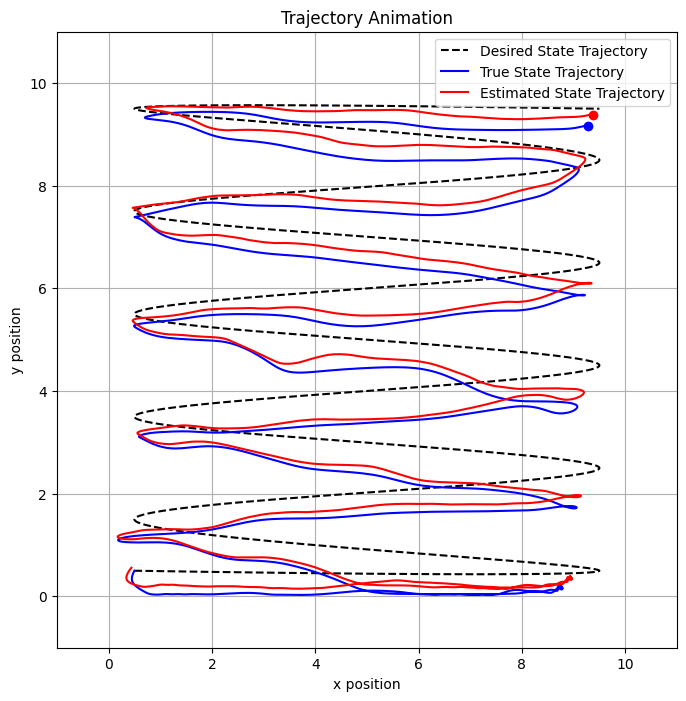

In [25]:
import matplotlib.animation as animation

# Stack histories (already done at the end of your sim)
state_history = jnp.stack(state_history)
state_hat_history = jnp.stack(state_hat_history)

t_samples = np.linspace(0, num_steps * dynamics.dt, num_steps)
x_des_history = spline_x(t_samples, 0)
y_des_history = spline_y(t_samples, 0)

# Set up figure
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-1, 11)
ax.set_ylim(-1, 11)
ax.set_xlabel("x position")
ax.set_ylabel("y position")
ax.set_title("Trajectory Animation")
ax.grid(True)

# Plot desired trajectory once (static)
ax.plot(x_des_history, y_des_history, 'k--', label="Desired State Trajectory")

# Lines that will be updated
true_line, = ax.plot([], [], 'b-', label="True State Trajectory")
hat_line, = ax.plot([], [], 'r-', label="Estimated State Trajectory")
true_point, = ax.plot([], [], 'bo', markersize=6)  # current true state
hat_point, = ax.plot([], [], 'ro', markersize=6)  # current estimated state

ax.legend(loc="upper right")

# Init function for animation
def init():
    true_line.set_data([], [])
    hat_line.set_data([], [])
    true_point.set_data([], [])
    hat_point.set_data([], [])
    return true_line, hat_line, true_point, hat_point

# Update function for animation
def update(frame):
    # Trails
    true_line.set_data(state_history[:frame, 0], state_history[:frame, 1])
    hat_line.set_data(state_hat_history[:frame, 0], state_hat_history[:frame, 1])
    # Current points (wrapped in lists!)
    true_point.set_data([state_history[frame, 0]], [state_history[frame, 1]])
    hat_point.set_data([state_hat_history[frame, 0]], [state_hat_history[frame, 1]])
    return true_line, hat_line, true_point, hat_point

# Create animation
ani = animation.FuncAnimation(
    fig, update, frames=num_steps, init_func=init,
    blit=True, interval=20, repeat=False
)

ani.save("trajectory.mp4", writer="ffmpeg", fps=30)

plt.show()

In [10]:
import jax_verify
from jax_verify.src import bound_propagation
import jax
import jax.numpy as jnp
from jax_verify import IntervalBound

def split_interval(bound: IntervalBound, num_splits: int = 2, split_dims=None):
    """Split an IntervalBound into smaller sub-intervals (batch tensor version).
    
    Args:
        bound: IntervalBound with shape (1, D).
        num_splits: number of splits per chosen dimension (e.g. 2 = bisect).
        split_dims: list/tuple of dimensions to split. If None, all dimensions.
        
    Returns:
        IntervalBound with shape (N, D), where N = num_splits**len(split_dims).
    """
    lower, upper = bound.lower[0], bound.upper[0]  # shape (D,)
    D = lower.shape[0]

    if split_dims is None:
        split_dims = jnp.arange(D)
    else:
        split_dims = jnp.array(split_dims)

    n_split_dims = split_dims.shape[0]
    n_intervals = num_splits ** n_split_dims

    # Build split points for each chosen dimension
    split_points = jnp.stack([
        jnp.linspace(lower[d], upper[d], num_splits + 1) for d in split_dims
    ])  # (n_split_dims, num_splits+1)

    # Generate all index combinations (base-num_splits counting)
    grid = jnp.arange(n_intervals)
    grid = jnp.stack([
        (grid // (num_splits**i)) % num_splits for i in range(n_split_dims)
    ], axis=-1)  # (N, n_split_dims)

    # Initialize batch lower/upper
    lo_batch = jnp.tile(lower, (n_intervals, 1))
    hi_batch = jnp.tile(upper, (n_intervals, 1))

    # Replace split dimensions with refined values
    def set_bounds(i, carry):
        lo, hi = carry
        dim = split_dims[i]
        idxs = grid[:, i]
        lo = lo.at[:, dim].set(split_points[i, idxs])
        hi = hi.at[:, dim].set(split_points[i, idxs + 1])
        return lo, hi

    lo_batch, hi_batch = jax.lax.fori_loop(
        0, n_split_dims, set_bounds, (lo_batch, hi_batch)
    )

    return IntervalBound(lo_batch, hi_batch)

In [15]:
epsilon = 0.1

state = jnp.array([4.0, 4.0, 0.0, 0.0])
obs = dynamics.get_observation(state, time=0)

pred_model = dynamics.get_state_estimate
interval_bounds = jax_verify.IntervalBound(
    jnp.array([obs - epsilon]),
    jnp.array([obs + epsilon])
)
jittable_input_bounds = interval_bounds.to_jittable()

def bound_prop_fun(inp_bound):
    (inp_bound,) = bound_propagation.unjit_inputs(inp_bound)

    bounds = jax_verify.backward_crown_bound_propagation(pred_model, inp_bound)
    lower = bounds.lower
    upper = bounds.upper

    return jnp.array(lower), jnp.array(upper)

out_lb, out_ub = bound_prop_fun(jittable_input_bounds)

lo = out_lb.flatten()
hi = out_ub.flatten()
state_bounds = hj.sets.Box(np.array(lo), np.array(hi))

print(f"Certified Min: {state_bounds.lo}")
print(f"Certified Max: {state_bounds.hi}")



Certified Min: [ 3.9612095  4.04573   -1.6699076 -1.5624415]
Certified Max: [4.7148776 4.6740665 2.063979  2.3261685]


In [16]:
# Empirical sampling inside perturbation region
num_samples = 10000
perturbations = np.random.uniform(
    low=-epsilon,
    high=epsilon,
    size=(num_samples, obs.shape[0])
)

sampled_obs = obs.flatten()[None, :] + perturbations
sampled_estimates = []

for i in range(num_samples):
    est = dynamics.get_state_estimate(jnp.array(sampled_obs[i])).flatten()
    sampled_estimates.append(np.array(est))

sampled_estimates = np.stack(sampled_estimates, axis=0)

empirical_min = sampled_estimates.min(axis=0)
empirical_max = sampled_estimates.max(axis=0)

print(f"Empirical Min: {empirical_min}")
print(f"Empirical Max: {empirical_max}")

Empirical Min: [ 4.1006646  4.151521  -1.0127101 -0.6674712]
Empirical Max: [4.5213175 4.5290318 1.3679006 1.7055374]


In [17]:
interval_bounds = jax_verify.IntervalBound(
    jnp.array([obs - epsilon]),
    jnp.array([obs + epsilon])
)
split_interval_bounds = split_interval(interval_bounds, num_splits=2, split_dims=[4, 7, 8, 9, 10, 11])
split_interval_bounds.lower.shape
jittable_input_bounds = split_interval_bounds.to_jittable()

def bound_prop_fun(inp_bound):
    (inp_bound,) = bound_propagation.unjit_inputs(inp_bound)

    bounds = jax_verify.backward_crown_bound_propagation(pred_model, inp_bound)
    lower = bounds.lower
    upper = bounds.upper
    
    return jnp.array(lower), jnp.array(upper)

out_lb, out_ub = bound_prop_fun(jittable_input_bounds)
lo = out_lb.min(axis=0)
hi = out_ub.max(axis=0)
# print(split_interval_bounds.lower.shape)
# print(out_lb, out_ub)
state_bounds_part = hj.sets.Box(np.array(lo), np.array(hi))

print(f"Certified Partitioned Min: {state_bounds_part.lo}")
print(f"Certified Partitioned Max: {state_bounds_part.hi}")

Certified Partitioned Min: [ 3.9968185  4.057893  -1.5979693 -1.4814605]
Certified Partitioned Max: [4.678495  4.6384106 2.0277748 2.2810066]


In [18]:
# Compare to certified bounds
print("Tightness check:")
for i, (lbp, ubp, lb, ub, e_min, e_max) in enumerate(
    zip(state_bounds_part.lo, state_bounds_part.hi, state_bounds.lo, state_bounds.hi, empirical_min, empirical_max)
):
    print(
        f"Dim {i}: certified partitioned [{lbp:.3f}, {ubp:.3f}], "
        f"certified [{lb:.3f}, {ub:.3f}], "
        f"empirical [{e_min:.3f}, {e_max:.3f}]"
    )

Tightness check:
Dim 0: certified partitioned [3.997, 4.678], certified [3.961, 4.715], empirical [4.101, 4.521]
Dim 1: certified partitioned [4.058, 4.638], certified [4.046, 4.674], empirical [4.152, 4.529]
Dim 2: certified partitioned [-1.598, 2.028], certified [-1.670, 2.064], empirical [-1.013, 1.368]
Dim 3: certified partitioned [-1.481, 2.281], certified [-1.562, 2.326], empirical [-0.667, 1.706]
